**<h1>Identifying Inappropriate Table of Surgical Procedures (TOSP) Pair Codes with KMeans Clustering</h1>**

<p align="justify">
In this notebook, we begin by analysing our problem statement using KMeans (covered in week 08) to determine whether it is a suitable model for grouping TOSP code descriptions and identifying inappropriate code pairs. Our analysis includes finding the optimal number of clusters for KMeans using both the Elbow Method and Silhouette Score.

---

## **1. Import Libraries and Setup**

Import the necessary libraries to set up the notebook.

In [1]:
# Import the required libraries
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Download Natural Language Toolkit (NLTK)
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **2. Data Loading and Pre-processing**

Loading the TOSP dataset (combined_dataset.csv) and applying the following pre-processing steps to enhance text quality:

* Convert text to lowercase - standardises input
* Removes numbers and punctuation reduces noise
* Removes stopwords - eliminates common but unimportant words
* Uses lemmatisation - reduces words to their base form for better clustering

<p align="justify">After preprocessing, we use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the cleaned descriptions into numerical representations. This technique assigns higher weights to important words determined by term frequency (TF) — <i>How many times does this word appear in this document among the number of times all words appear in this document? and <i>Inverse Document Frequency (IDF) — <i>How common (or uncommon) is this word among all the documents I have?</i>

---

In [2]:
# Loading the data (combined_dataset.csv)
df_tosp = pd.read_csv("combined_dataset.csv")

# Data pre-processing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(words)

df_tosp["Cleaned_Description"] = df_tosp["Description"].apply(preprocess_text)

# Display first 3 samples of the processed descriptions
print("\nSample of cleaned descriptions:")
for i, text in enumerate(df_tosp["Cleaned_Description"].head(3)):
    print(f"Original: {df_tosp['Description'].iloc[i][:100]}...")
    print(f"Cleaned: {text[:100]}...")
    print("-" * 50)


Sample of cleaned descriptions:
Original: BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS...
Cleaned: botulinum toxin therapy movement disorder...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)...
Cleaned: breast ductal lesion microdochectomy bilateral...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)...
Cleaned: breast ductal lesion microdochectomy unilateral...
--------------------------------------------------


In [3]:
# Extract descriptions and vectorize them using TF‑IDF
descriptions = df_tosp["Cleaned_Description"].tolist()
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(descriptions)

## **3. Finding the best "K" value for KMeans with Elbow Method and Silhouette Analysis**

<p align="justify">
To determine the optimal number of clusters (K) for KMeans, we use both the Elbow Method and Silhouette Analysis. The Elbow Method examines the Sum of Squared Errors (SSE), where a sharp bend (or "elbow") in the plot indicates the ideal K value that balances cluster compactness and complexity. The Silhouette Score measures the quality of clustering, with higher scores indicating well-separated and cohesive clusters.

---

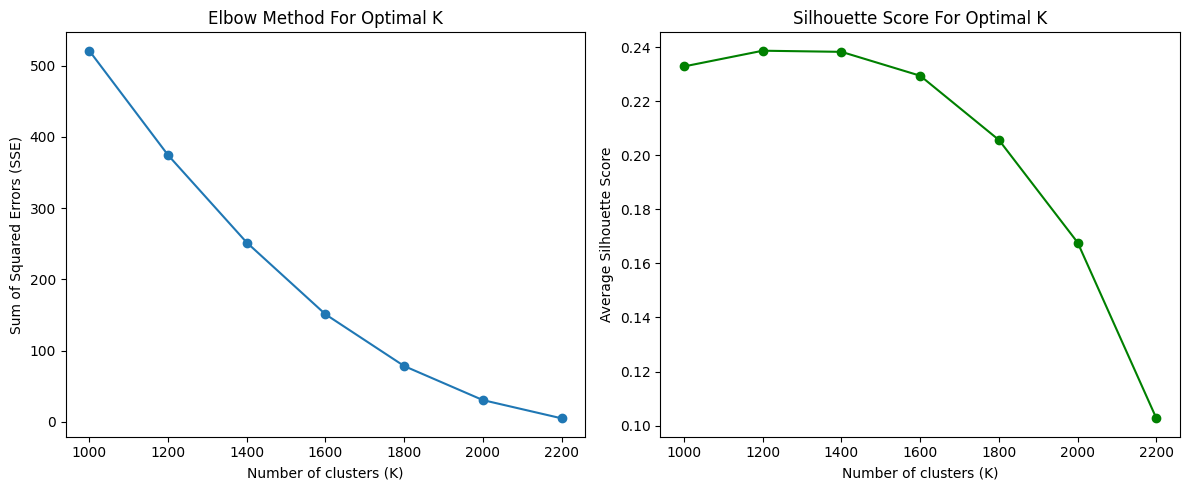

Optimal K (Elbow Method): 1200
Optimal K (Silhouette Score): 1200


In [4]:
# Finding the best n_clusters via Elbow Method and Silhouette Analysis

# Define the range of K values to test
# We have tested from 1 - 2364 (Max no. of rows in our .csv), plotting from 1K to show a clearer graph
K_range = range(1000, 2400, 200)

sse = [] # Sum of squared errors for each k (for Elbow Method)
silhouette_scores = [] # Average silhouette score for each k

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_) # Inertia: sum of squared distances to cluster centers

    # Compute the silhouette score using Euclidean distance
    score = silhouette_score(X, kmeans.labels_, metric='euclidean')
    silhouette_scores.append(score)

# Plotting the Elbow Method and Silhouette Scores side by side
plt.figure(figsize=(12, 5))

# Elbow Method plot
plt.subplot(1, 2, 1)
plt.plot(list(K_range), sse, marker='o')
plt.title("Elbow Method For Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Sum of Squared Errors (SSE)")

# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(list(K_range), silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score For Optimal K")
plt.xlabel("Number of clusters (K)")
plt.ylabel("Average Silhouette Score")

plt.tight_layout()
plt.show()

# Optimal K for the Elbow Method (point where SSE decrease slows down)
second_derivative = np.diff(sse, 2)  # Compute second derivative of SSE
optimal_k_elbow = K_range[np.argmin(second_derivative)]

# Finding the optimal K for Silhouette Score (highest score)
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]

# Print optimal K from both methods
print(f"Optimal K (Elbow Method): {optimal_k_elbow}")
print(f"Optimal K (Silhouette Score): {optimal_k_silhouette}")

<p align="justify">
When using KMeans with a cluster range from 1000 to 2400 (in increments of 200), we observed that SSE approaches near zero at around 2200 clusters (2364 TOSP codes in the dataset). This suggests that with such a high number of clusters, most data points (each surgery procedure) are effectively isolated, indicating overfitting rather than meaningful grouping. Meanwhile, the silhouette score peaks at around 0.24 at 1200 clusters, suggesting that even the best-performing KMeans configuration results in weakly separated clusters. This indicates that KMeans may not be the most effective model for this dataset.

## **4. Training the models and comparing TOSP Code Pairs**

<p align ="justify">
The KMeans model was trained using the optimal parameters identified in our analysis. Since we do not have access to medical professionals for validation, our evaluation relies on manual inspection. Specifically, we assess similarity by identifying repeated keywords—such as "cataract surgery"—in the TOSP code descriptions to determine whether code pairs should be considered similar or different.

---

In [5]:
# Training KMeans Clustering
n_clusters = 1200  # Based on silhouette score
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Assign KMeans cluster labels to the dataframe
df_tosp["KMeans_Label"] = kmeans_labels

# Defining a function to test a pair of codes
def test_code_pair(code1, code2, df, vectorizer):
    # Locate the indices of the provided codes
    idx1_list = df.index[df["Code"] == code1].tolist()
    idx2_list = df.index[df["Code"] == code2].tolist()

    if not idx1_list or not idx2_list:
        print(f"One or both codes ({code1}, {code2}) were not found.")
        return

    idx1 = idx1_list[0]
    idx2 = idx2_list[0]

    # Retrieve the TOSP code descriptions
    desc1 = df.loc[idx1, "Description"]
    desc2 = df.loc[idx2, "Description"]

    # Get cluster labels from KMeans
    kmeans_label1 = df.loc[idx1, "KMeans_Label"]
    kmeans_label2 = df.loc[idx2, "KMeans_Label"]

    same_kmeans = (kmeans_label1 == kmeans_label2)

    # Compute cosine similarity using TF‑IDF vectors
    vec1 = vectorizer.transform([desc1])
    vec2 = vectorizer.transform([desc2])
    cos_sim = cosine_similarity(vec1, vec2)[0][0]

    # Output the results
    print(f"Comparing code pair: {code1} vs {code2}")
    print(f"KMeans -> {code1} in cluster {kmeans_label1}, {code2} in cluster {kmeans_label2}. Same cluster: {same_kmeans}")
    print(f"Cosine similarity (TF‑IDF): {cos_sim:.4f}")

# Test the function with a specific pair of codes
# In example #1 below, we will compare codes "SL701L" and "SL702L"
# SL701L - LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY
# SL702L - LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL
# As you can see, since both TOSP are similar in description, the cosine similarity is high, and KMeans is clustering them together
test_code_pair("SL701L", "SL702L", df_tosp, vectorizer)

print()

# In example #2 below, we will compare codes "SL702L" and "SL705O"
# SL702L - LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL
# SL705O ORBIT, VARIOUS LESIONS, EXTENDED LATERAL ORBITOTOMY
# KMeans is correctly clustering them separately (both are vastly different operations, even though they are eye-related surgeries)
# The cosine similarity seems to be correct as well, as both codes have no common words in their descriptions
test_code_pair("SL701L", "SL705O", df_tosp, vectorizer)

Comparing code pair: SL701L vs SL702L
KMeans -> SL701L in cluster 320, SL702L in cluster 320. Same cluster: True
Cosine similarity (TF‑IDF): 0.9597

Comparing code pair: SL701L vs SL705O
KMeans -> SL701L in cluster 320, SL705O in cluster 275. Same cluster: False
Cosine similarity (TF‑IDF): 0.0000


## **6. Saving the KMeans Model**

<p align="justify">
To avoid retraining, we save the trained KMeans model and TF-IDF vectorizer using joblib. This allows us to reuse them later without recomputing clusters.

In [6]:
import joblib

# Save KMeans model
joblib.dump(kmeans, "KMeans_Model.pkl")

print("KMeans Clustering Model saved successfully!")

KMeans Clustering Model saved successfully!


## **6. Conclusion and Suggestions Moving Forward**

<p align="justify">
Our testing reveals that <b>KMeans</b>, when applied to TF-IDF representations of TOSP code descriptions, does not yield an entirely satisfactory clustering solution for identifying inappropriate code pairs. The model appears to overfit the data, forming clusters that lack clear separation—reflected by a low silhouette score—and splitting codes that, based on domain intuition (not medically reviewed), should be grouped together. This suggests that KMeans may not effectively capture the nuanced relationships between procedure descriptions, limiting its ability to identify inappropriate code pairings.

<p align="justify">
To improve clustering effectiveness, future analyses could focus on using a subset of the dataset—for example, filtering only "SL" (Eye Procedures) and "SJ" (Endocrine Procedures)—to allow for more precise domain-specific clustering. Additionally, we will attempt to explore alternative clustering models such as DBSCAN and Agglomerative Hierarchical Clustering in subsequent notebooks. These methods may offer better adaptability to the inherent structure of the data by leveraging on density-based or hierarchical grouping approaches. Further refinement of feature representations, such as word embeddings (e.g., Word2Vec or BERT) instead of TF‑IDF, could also enhance the ability to capture semantic similarities between procedure descriptions.

---